In [1]:
import os
import numpy as np
import threading as thr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

In [7]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [12]:
mammo_o, mammo_f, label = [], [], []
data_folder = "C:/Users/anapascual/exam_project/train_val_dataset/"
os.chdir(data_folder)
l = os.listdir()

In [13]:
def create_dataset(lista, o_img, f_img, labels):
    """Function calling the Matlab file in order to filter the images.
    
    Arguments
    ---------
    
    lista : list
        Chunk of file directories.
    
    Return:
        Dataset with all the images filtered.
    """
    
    for element in lista:
        if "_1_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(1)
        elif "_2_resized.pgm" in element:
            mo, mf = eng.dataset_filtered(eng.char(os.path.join(data_folder, element)), nargout = 2)
            o_img.append(mo)
            f_img.append(mf)
            labels.append(0)

In [14]:
os.chdir("C:/Users/anapascual/exam_project/")
threads = []
chunk = 6

for i in range(49):
    t = thr.Thread(target = create_dataset, args = (l[i*chunk : (i+1)*chunk], mammo_o, mammo_f, label))
    threads.append(t)
    t.start()
    
for j in threads:
    j.join()

In [16]:
eng.quit()

In [17]:
mammo_o = np.asarray(mammo_o, dtype = 'float32')/255.
mammo_f = np.asarray(mammo_f, dtype = 'float32')/255.
label = np.asarray(label)

In [18]:
mammo_o_4d = np.reshape(mammo_o, (147, 125, 125, 1))
mammo_f_4d = np.reshape(mammo_f, (147, 64, 64, 1))

In [34]:
def cnn_o(shape=(125, 125, 1)):
    model = Sequential([
        
        Conv2D(6, (5,5), padding = 'same', input_shape = shape),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.2),
        
        
        Conv2D(6, (5,5), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.1),
        
        
        Conv2D(10, (5,5), padding = 'same'),
        BatchNormalization(),
        Activation('relu'),
        
        MaxPool2D((6,6), strides = 2),
        #Dropout(0.1),
        
        Flatten(),
        
        Dense(10, activation = 'relu'),
        #Dropout(0.1),
        Dense(1, activation = 'sigmoid')        
        
    ])
    
    return model

In [35]:
model_o = cnn_o()
model_o.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 125, 125, 6)       156       
                                                                 
 batch_normalization_6 (Batc  (None, 125, 125, 6)      24        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 125, 125, 6)       0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 60, 60, 6)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 6)         906       
                                                                 
 batch_normalization_7 (Batc  (None, 60, 60, 6)       

In [36]:
learning_rate = 0.001
model_o.compile(optimizer = SGD(learning_rate, momentum = 0.9), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

In [ ]:
aug = ImageDataGenerator(
                rotation_range = 90,
                horizontal_flip = True,
                vertical_flip = True,
                validation_split = 0.21)

Xaug_train_o = aug.flow(mammo_o_4d, batch_size = 30, subset = 'training')
Xaug_val_o = aug.flow(mammo_o_4d, batch_size = 30, subset = 'validation')

In [39]:
X_train_o, X_val_o, Y_train_o, Y_val_o = train_test_split(mammo_o_4d, label, test_size = 0.2, random_state = 44)
batch_size = 21
traino = model_o.fit(X_train_o, Y_train_o, 
                     batch_size = batch_size,
                     epochs = 200, 
                     verbose=1,
                     validation_data=(X_val_o, Y_val_o),
                     callbacks = [reduce_on_plateau])    

Epoch 1/200
6/6 [==============================] - 1s 171ms/step - loss: 0.3124 - accuracy: 0.8803 - val_loss: 0.2151 - val_accuracy: 0.9333 - lr: 1.0000e-22
Epoch 2/200
6/6 [==============================] - 1s 180ms/step - loss: 0.3159 - accuracy: 0.8803 - val_loss: 0.2157 - val_accuracy: 0.9333 - lr: 1.0000e-22
Epoch 3/200
6/6 [==============================] - 1s 181ms/step - loss: 0.3086 - accuracy: 0.8718 - val_loss: 0.2163 - val_accuracy: 0.9333 - lr: 1.0000e-22
Epoch 4/200
6/6 [==============================] - 1s 179ms/step - loss: 0.3329 - accuracy: 0.8803 - val_loss: 0.2173 - val_accuracy: 0.9333 - lr: 1.0000e-22
Epoch 5/200
6/6 [==============================] - 1s 181ms/step - loss: 0.3168 - accuracy: 0.8803 - val_loss: 0.2177 - val_accuracy: 0.9333 - lr: 1.0000e-22
Epoch 6/200
6/6 [==============================] - 1s 166ms/step - loss: 0.3145 - accuracy: 0.8889 - val_loss: 0.2178 - val_accuracy: 0.9333 - lr: 1.0000e-22
Epoch 7/200
6/6 [==============================] - 1

6/6 [==============================] - 1s 171ms/step - loss: 0.3148 - accuracy: 0.8889 - val_loss: 0.2270 - val_accuracy: 0.9333 - lr: 1.0000e-32
Epoch 104/200
6/6 [==============================] - 1s 166ms/step - loss: 0.3309 - accuracy: 0.8803 - val_loss: 0.2268 - val_accuracy: 0.9333 - lr: 1.0000e-32
Epoch 105/200
6/6 [==============================] - 1s 167ms/step - loss: 0.3169 - accuracy: 0.8803 - val_loss: 0.2269 - val_accuracy: 0.9333 - lr: 1.0000e-32
Epoch 106/200
6/6 [==============================] - 1s 175ms/step - loss: 0.3372 - accuracy: 0.8547 - val_loss: 0.2269 - val_accuracy: 0.9333 - lr: 1.0000e-32
Epoch 107/200
6/6 [==============================] - 1s 166ms/step - loss: 0.3189 - accuracy: 0.8718 - val_loss: 0.2269 - val_accuracy: 0.9333 - lr: 1.0000e-32
Epoch 108/200
6/6 [==============================] - 1s 171ms/step - loss: 0.3156 - accuracy: 0.8803 - val_loss: 0.2272 - val_accuracy: 0.9333 - lr: 1.0000e-32
Epoch 109/200
6/6 [==============================] - 1

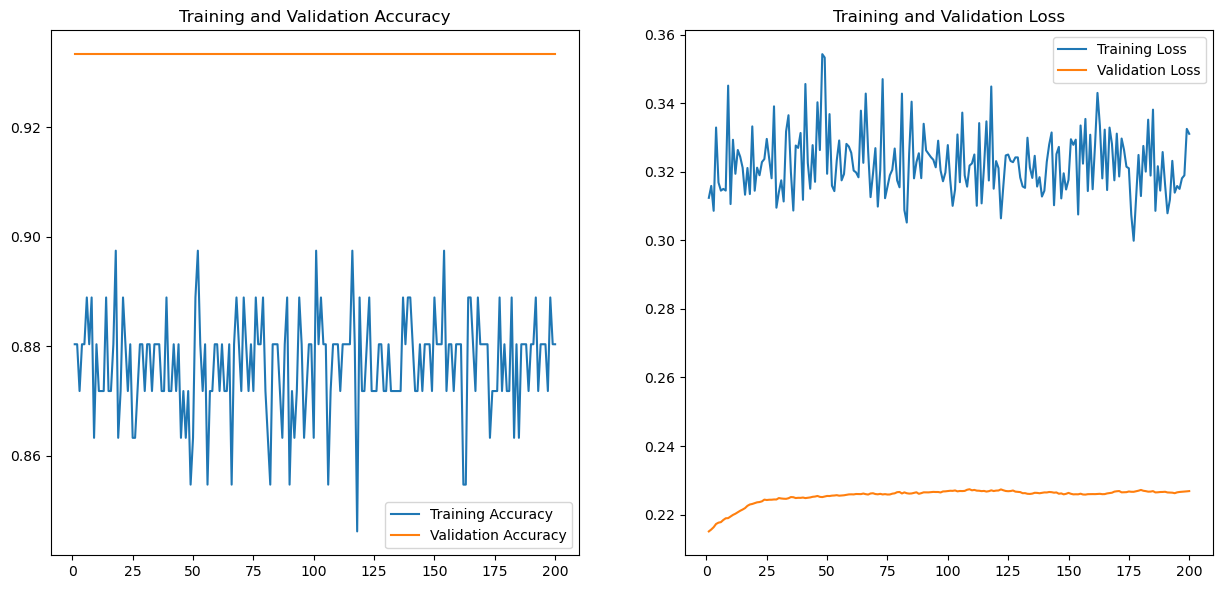

In [40]:
acc = traino.history['accuracy']
val_acc = traino.history['val_accuracy']
loss = traino.history['loss']
val_loss = traino.history['val_loss']

epochs_range = range(1, len(acc)+1)

#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation accuracy: 0.933
1/1 [==============================] - 0s 232ms/step


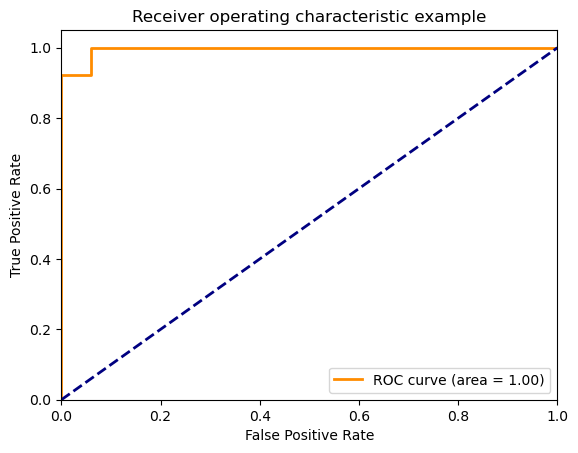

In [41]:
_, val_acc = model_o.evaluate(X_val_o, Y_val_o, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))

preds = model_o.predict(X_val_o, verbose=1)

#Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(Y_val_o, preds)
roc_auc = auc(fpr, tpr)

#Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()